In [1]:
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
from nxcals.api.extraction.data.builders import *

import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

Matplotlib is building the font cache; this may take a moment.


In [149]:
start = str(df_gain.timestamp.min())
end = str(df_gain.timestamp.max())

# 650 MeV

Text(0.5, 1.0, 'RFKO gain logging 650 MeV/u')

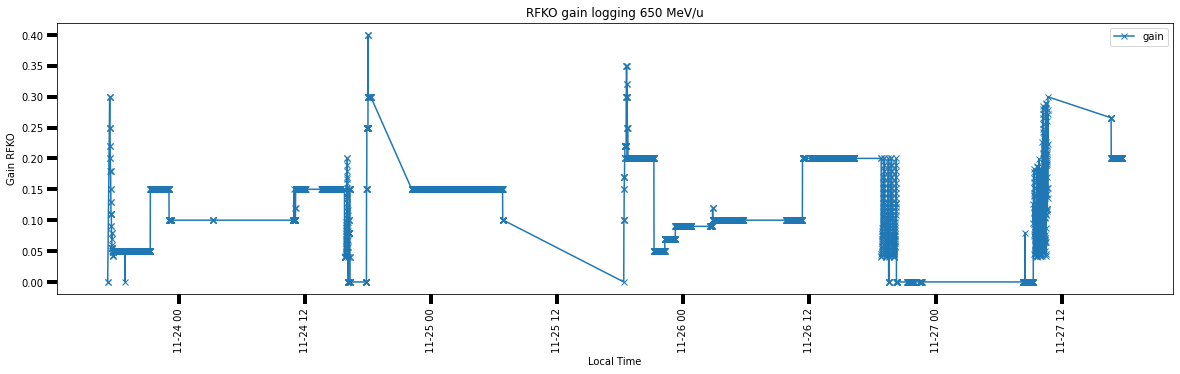

In [89]:
my_path = "logging_MD5_2022_11_23_17h15m19s"
with open("/eos/user/e/eljohnso/SWAN_projects/quad-scan-east/logging_MD5/"+my_path+"/"+my_path+".p", 'rb') as f:
    data = pickle.load(f)

gain_list = []
for i in range(len(data[1]["PR.BQL72/Setting"])):
    gain = data[1]["PR.BQL72/Setting"][i]["exAmplitudeH"]
    gain_list.append(gain)
    
timestamp_gain = np.array(data[0])

d = {'timestamp': timestamp_gain, 'gain': gain_list}
df_gain = pd.DataFrame(data=d)
df_gain.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
df_gain_650 = df_gain


fig, ax = plt.subplots(figsize=(20,5))

ax.plot(timestamp_gain, gain_list, label="gain", marker="x")

ax.legend()
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Local Time")
ax.set_ylabel("Gain RFKO")
ax.set_title("RFKO gain logging 650 MeV/u")

In [90]:
df_xsec_70 = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XSEC070-I/IntensityMeasurement").build().toPandas()
df_xsec_70_spill = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XSEC070-I/SpillData").build().toPandas()
df_xsec_70_spill = df_xsec_70_spill.dropna()

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


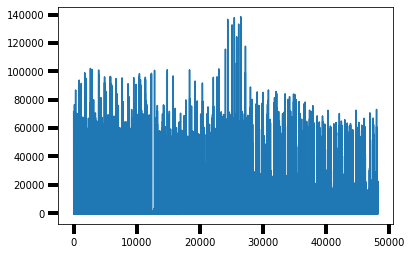

In [91]:
plt.plot(df_xsec_70_spill.semSpillData.apply(lambda x: -(x["elements"].sum()*125/400)))

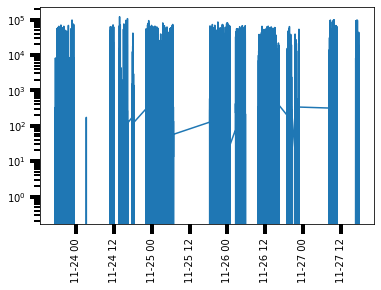

In [92]:
flux = df_xsec_70_spill.semSpillData.apply(lambda x: -(x["elements"].sum()*125/400))
d = {'timestamp': df_xsec_70.where(df_xsec_70.selector=="CPS.USER.MD5").acqStamp, 'intensity': df_xsec_70.where(df_xsec_70.selector=="CPS.USER.MD5").intensity, 'flux': flux}
df_xsec = pd.DataFrame(data=d)

df_xsec = df_xsec.dropna()
df_xsec["timestamp"] = df_xsec["timestamp"]/1000000000
df_xsec["timestamp"] = [datetime.fromtimestamp(x) for x in df_xsec["timestamp"]]
df_xsec.sort_values(by=['timestamp'], inplace=True)

fig, ax = plt.subplots()
ax.plot(df_xsec.timestamp, df_xsec.flux)
ax.set_yscale("log")
ax.tick_params(axis='x', rotation=90)

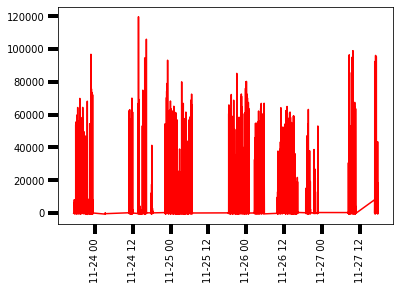

In [93]:
fig, ax = plt.subplots()

ax.plot(df_xsec.timestamp, df_xsec.flux, c="r")
ax.tick_params(axis='x', rotation=90)

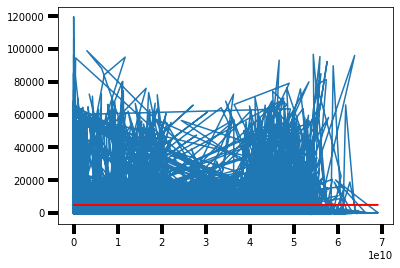

In [94]:
fig, ax = plt.subplots()
plt.plot(df_xsec.intensity, df_xsec.flux)

x = df_xsec.intensity
y = df_xsec.flux

from scipy import stats
res = stats.linregress(x, y)
ax.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

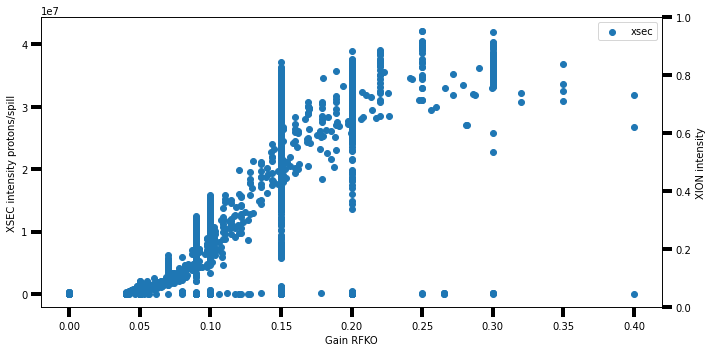

In [95]:
merge_xsec = pd.merge_asof(df_gain, df_xsec, on="timestamp", direction="nearest")
merge_xsec_650 = pd.merge_asof(df_gain, df_xsec, on="timestamp", direction="nearest")

fig, ax = plt.subplots(tight_layout=True, figsize=(10,5))

ax.scatter(merge_xsec.gain, merge_xsec.intensity*6.1e-4, label="xsec")
ax2 = ax.twinx()
ax.set_xlabel("Gain RFKO")
ax.set_ylabel("XSEC intensity protons/spill")
ax2.set_ylabel("XION intensity")

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

# 750 MeV EAST3

Text(0.5, 1.0, 'RFKO gain logging 750 MeV/u')

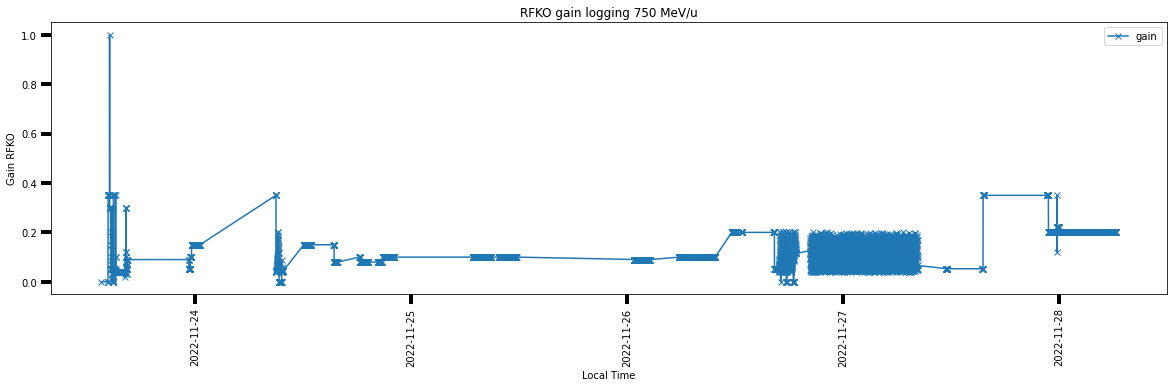

In [96]:
d = {'timestamp': [], 'gain': []}
df_gain = pd.DataFrame(data=d)
for path in ["logging_EAST3_2022_11_23_13h36m48s", "logging_EAST3_2022_11_24_09h29m48s"]:
    my_path = path
    with open("/eos/user/e/eljohnso/SWAN_projects/quad-scan-east/logging_EAST3/"+my_path+"/"+my_path+".p", 'rb') as f:
        data = pickle.load(f)

    gain_list = []
    for i in range(len(data[1]["PR.BQL72/Setting"])):
        gain = data[1]["PR.BQL72/Setting"][i]["exAmplitudeH"]
        gain_list.append(gain)

    timestamp_gain = np.array(data[0])

    d = {'timestamp': timestamp_gain, 'gain': gain_list}
    df = pd.DataFrame(data=d)
    df.sort_values(by=['timestamp'], inplace=True, ignore_index=True)

    df_gain = pd.concat([df,df_gain])

df_gain.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
df_gain_750 = df_gain

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df_gain.timestamp, df_gain.gain, label="gain", marker="x")

ax.legend()
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Local Time")
ax.set_ylabel("Gain RFKO")
ax.set_title("RFKO gain logging 750 MeV/u")

In [97]:
df_xsec_70 = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XSEC070-I/IntensityMeasurement").build().toPandas()

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


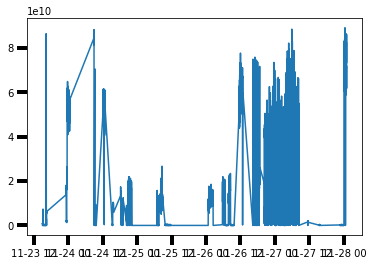

In [98]:
d = {'timestamp': df_xsec_70.where(df_xsec_70.selector=="CPS.USER.EAST3").acqStamp, 'intensity': df_xsec_70.where(df_xsec_70.selector=="CPS.USER.EAST3").intensity}
df_xsec = pd.DataFrame(data=d)

df_xsec = df_xsec.dropna()
df_xsec["timestamp"] = df_xsec["timestamp"]/1000000000
df_xsec["timestamp"] = [datetime.fromtimestamp(x) for x in df_xsec["timestamp"]]
df_xsec.sort_values(by=['timestamp'], inplace=True)

fig, ax = plt.subplots()
ax.plot(df_xsec.timestamp, df_xsec.intensity)

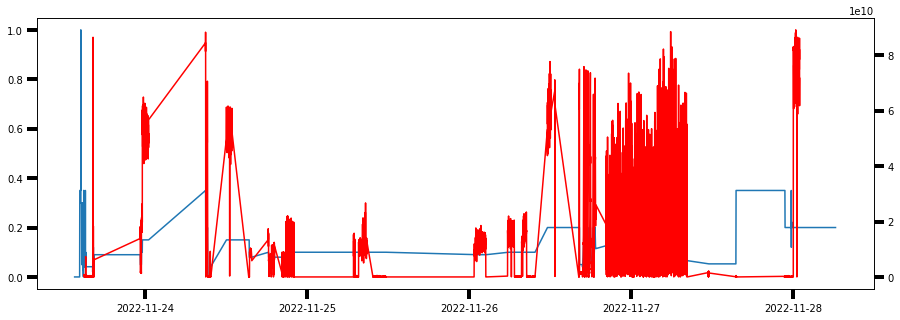

In [99]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df_gain.timestamp, df_gain.gain)
ax2 = ax.twinx()
ax2.plot(df_xsec.timestamp, df_xsec.intensity, c="r")

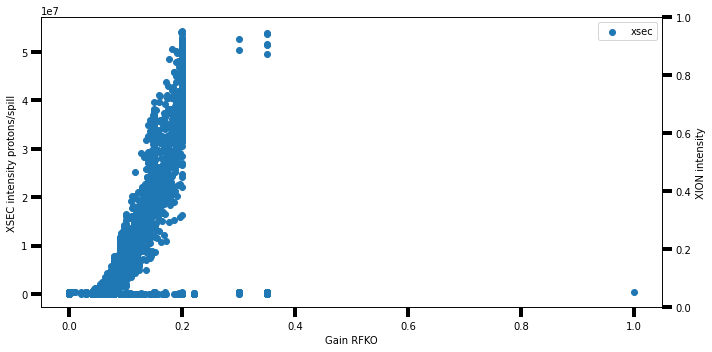

In [100]:
merge_xsec = pd.merge_asof(df_gain, df_xsec, on="timestamp", direction="nearest")
merge_xsec_750 = pd.merge_asof(df_gain, df_xsec, on="timestamp", direction="nearest")

fig, ax = plt.subplots(tight_layout=True, figsize=(10,5))

ax.scatter(merge_xsec.gain, merge_xsec.intensity*6.1e-4, label="xsec")
ax2 = ax.twinx()
ax.set_xlabel("Gain RFKO")
ax.set_ylabel("XSEC intensity protons/spill")
ax2.set_ylabel("XION intensity")

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

# 1000 MeV

Text(0.5, 1.0, 'RFKO gain logging 1000 MeV/u')

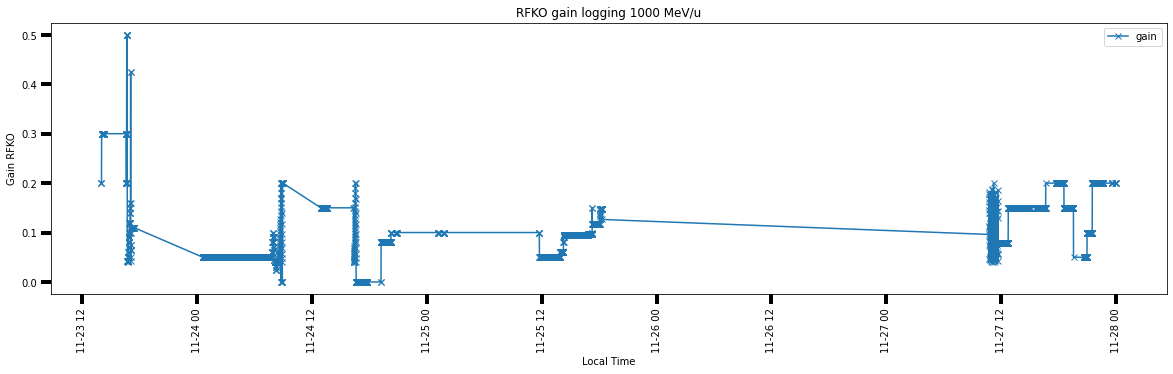

In [101]:
my_path = "logging_EAST4_2022_11_23_14h00m04s"
with open("/eos/user/e/eljohnso/SWAN_projects/quad-scan-east/logging_EAST4/"+my_path+"/"+my_path+".p", 'rb') as f:
    data = pickle.load(f)

gain_list = []
for i in range(len(data[1]["PR.BQL72/Setting"])):
    gain = data[1]["PR.BQL72/Setting"][i]["exAmplitudeH"]
    gain_list.append(gain)
    
timestamp_gain = np.array(data[0])[:-1]

d = {'timestamp': timestamp_gain, 'gain': gain_list}
df_gain = pd.DataFrame(data=d)
df_gain.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
df_gain_1000 = df_gain

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(timestamp_gain, gain_list, label="gain", marker="x")

ax.legend()
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Local Time")
ax.set_ylabel("Gain RFKO")
ax.set_title("RFKO gain logging 1000 MeV/u")

In [102]:
df_xsec_70 = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XSEC070-I/IntensityMeasurement").build().toPandas()

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


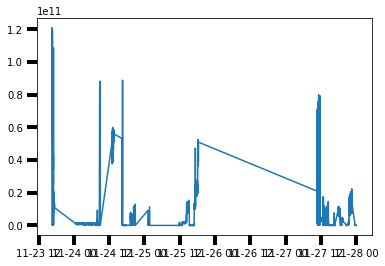

In [103]:
d = {'timestamp': df_xsec_70.where(df_xsec_70.selector=="CPS.USER.EAST4").acqStamp, 'intensity': df_xsec_70.where(df_xsec_70.selector=="CPS.USER.EAST4").intensity}
df_xsec = pd.DataFrame(data=d)

df_xsec = df_xsec.dropna()
df_xsec["timestamp"] = df_xsec["timestamp"]/1000000000
df_xsec["timestamp"] = [datetime.fromtimestamp(x) for x in df_xsec["timestamp"]]
df_xsec.sort_values(by=['timestamp'], inplace=True)

fig, ax = plt.subplots()
ax.plot(df_xsec.timestamp, df_xsec.intensity)

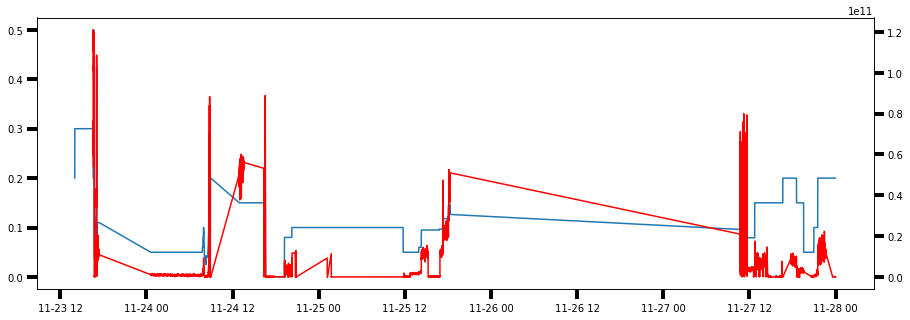

In [104]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df_gain.timestamp, df_gain.gain)
ax2 = ax.twinx()
ax2.plot(df_xsec.timestamp, df_xsec.intensity, c="r")

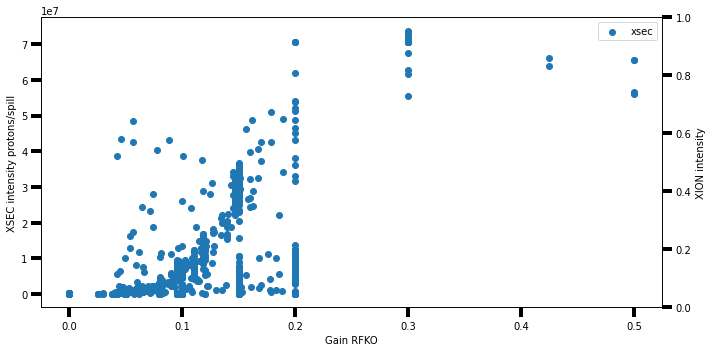

In [105]:
merge_xsec = pd.merge_asof(df_gain, df_xsec, on="timestamp", direction="nearest")
merge_xsec_1000 = pd.merge_asof(df_gain, df_xsec, on="timestamp", direction="nearest")

fig, ax = plt.subplots(tight_layout=True, figsize=(10,5))

ax.scatter(merge_xsec.gain, merge_xsec.intensity*6.1e-4, label="xsec")
ax2 = ax.twinx()
ax.set_xlabel("Gain RFKO")
ax.set_ylabel("XSEC intensity protons/spill")
ax2.set_ylabel("XION intensity")

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

# All beams

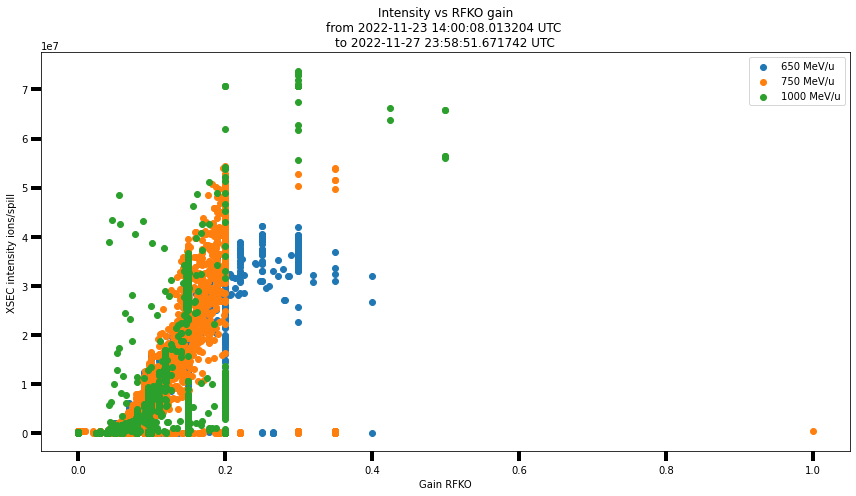

In [106]:
merge_xsec_650.sort_values(by=['gain'], inplace=True)
merge_xsec_750.sort_values(by=['gain'], inplace=True)
merge_xsec_1000.sort_values(by=['gain'], inplace=True)

fig, ax = plt.subplots(tight_layout=True, figsize=(12,7))

ax.scatter(merge_xsec_650.gain, merge_xsec_650.intensity*6.1e-4, label=f"650 MeV/u")
ax.scatter(merge_xsec_750.gain, merge_xsec_750.intensity*6.1e-4, label=f"750 MeV/u")
ax.scatter(merge_xsec_1000.gain, merge_xsec_1000.intensity*6.1e-4, label=f"1000 MeV/u")


ax.set_xlabel("Gain RFKO")
ax.set_ylabel("XSEC intensity ions/spill")
ax.set_title(f"Intensity vs RFKO gain\nfrom {start} UTC \nto {end} UTC")
ax.legend()
# ax.set_xlim(0.02,0.2)
# ax.set_ylim(1e4,6e7)
# ax.set_yscale("log")

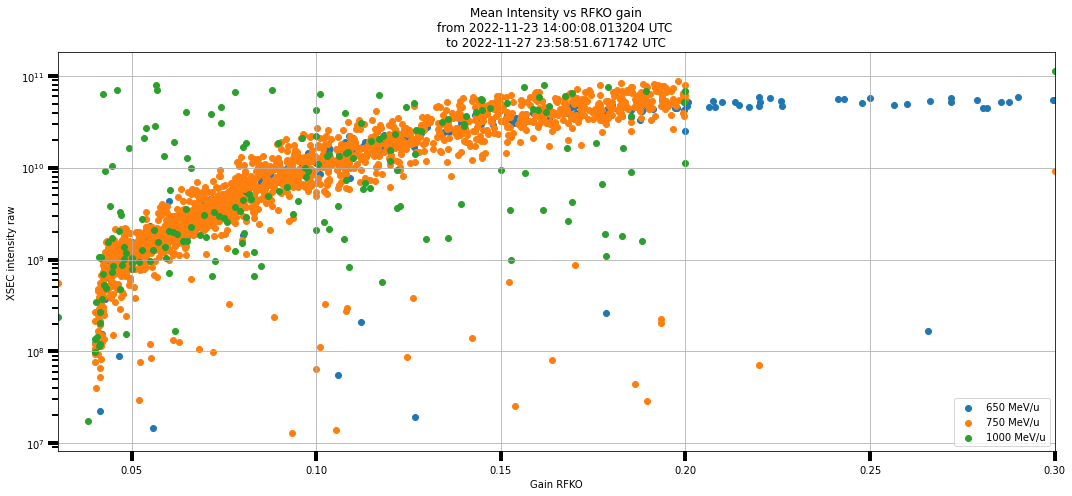

In [107]:
fig, ax = plt.subplots(tight_layout=True, figsize=(15,7))

intensity_l = []
for unique_gain in merge_xsec_650.gain.unique():
    intensity_l.append(merge_xsec_650.where(merge_xsec_650.gain == unique_gain).intensity.mean())

ax.scatter(merge_xsec_650.gain.unique(), np.array(intensity_l), label=f"650 MeV/u")

intensity_l = []
for unique_gain in merge_xsec_750.gain.unique():
    intensity_l.append(merge_xsec_750.where(merge_xsec_750.gain == unique_gain).intensity.mean())

ax.scatter(merge_xsec_750.gain.unique(), np.array(intensity_l), label=f"750 MeV/u")

intensity_l = []
for unique_gain in merge_xsec_1000.gain.unique():
    intensity_l.append(merge_xsec_1000.where(merge_xsec_1000.gain == unique_gain).intensity.mean())

ax.scatter(merge_xsec_1000.gain.unique(), np.array(intensity_l), label=f"1000 MeV/u")

ax.set_xlim(0.03,0.3)
ax.set_xlabel("Gain RFKO")
ax.set_ylabel("XSEC intensity raw")
ax.set_title(f"Mean Intensity vs RFKO gain\nfrom {start} UTC \nto {end} UTC")
ax.legend()
ax.set_yscale("log")
# ax.set_ylim(1e4,1e8)
ax.grid()

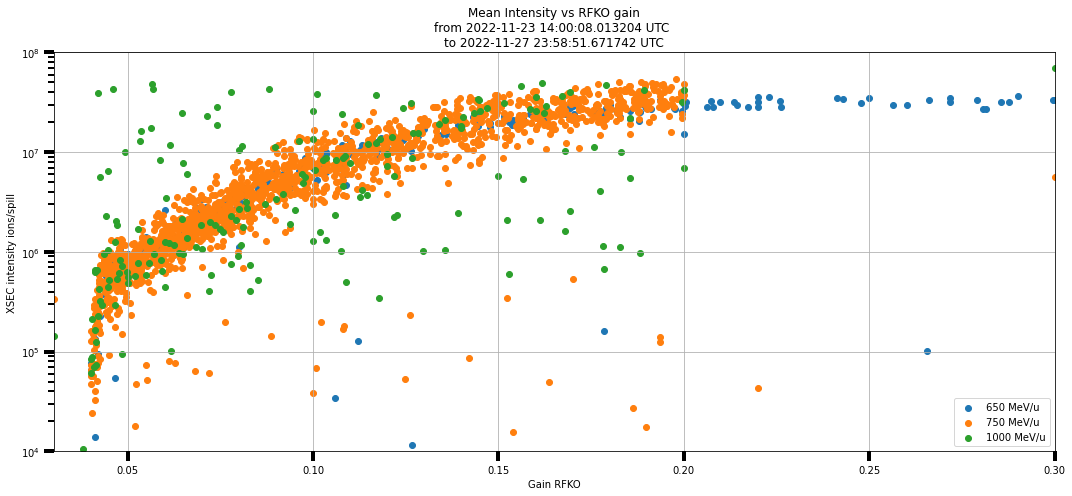

In [108]:
fig, ax = plt.subplots(tight_layout=True, figsize=(15,7))

intensity_l = []
for unique_gain in merge_xsec_650.gain.unique():
    intensity_l.append(merge_xsec_650.where(merge_xsec_650.gain == unique_gain).intensity.mean())

ax.scatter(merge_xsec_650.gain.unique(), np.array(intensity_l)*6.1e-4, label=f"650 MeV/u")

intensity_l = []
for unique_gain in merge_xsec_750.gain.unique():
    intensity_l.append(merge_xsec_750.where(merge_xsec_750.gain == unique_gain).intensity.mean())

ax.scatter(merge_xsec_750.gain.unique(), np.array(intensity_l)*6.1e-4, label=f"750 MeV/u")

intensity_l = []
for unique_gain in merge_xsec_1000.gain.unique():
    intensity_l.append(merge_xsec_1000.where(merge_xsec_1000.gain == unique_gain).intensity.mean())

ax.scatter(merge_xsec_1000.gain.unique(), np.array(intensity_l)*6.1e-4, label=f"1000 MeV/u")

ax.set_xlim(0.03,0.3)
ax.set_xlabel("Gain RFKO")
ax.set_ylabel("XSEC intensity ions/spill")
ax.set_title(f"Mean Intensity vs RFKO gain\nfrom {start} UTC \nto {end} UTC")
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e4,1e8)
ax.grid()

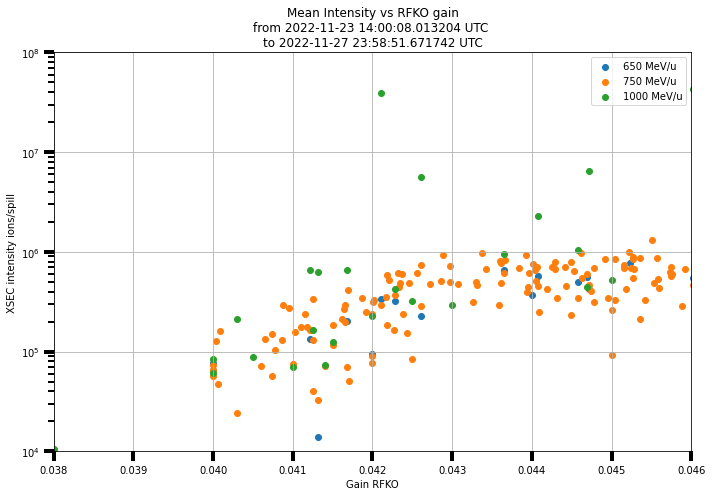

In [109]:
fig, ax = plt.subplots(tight_layout=True, figsize=(10,7))

intensity_l = []
for unique_gain in merge_xsec_650.gain.unique():
    intensity_l.append(merge_xsec_650.where(merge_xsec_650.gain == unique_gain).intensity.mean())

ax.scatter(merge_xsec_650.gain.unique(), np.array(intensity_l)*6.1e-4, label=f"650 MeV/u")

intensity_l = []
for unique_gain in merge_xsec_750.gain.unique():
    intensity_l.append(merge_xsec_750.where(merge_xsec_750.gain == unique_gain).intensity.mean())

ax.scatter(merge_xsec_750.gain.unique(), np.array(intensity_l)*6.1e-4, label=f"750 MeV/u")

intensity_l = []
for unique_gain in merge_xsec_1000.gain.unique():
    intensity_l.append(merge_xsec_1000.where(merge_xsec_1000.gain == unique_gain).intensity.mean())

ax.scatter(merge_xsec_1000.gain.unique(), np.array(intensity_l)*6.1e-4, label=f"1000 MeV/u")

ax.set_xlim(0.038,0.046)
ax.set_xlabel("Gain RFKO")
ax.set_ylabel("XSEC intensity ions/spill")
ax.set_title(f"Mean Intensity vs RFKO gain\nfrom {start} UTC \nto {end} UTC")
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e4,1e8)
# ax.set_xticks()
ax.grid()

# XION

In [110]:
start = "2022-11-26 08:00:00.000" # UTC
end ="2022-11-26 10:00:00.000" # UTC

df_xion = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XION070-I/SpillData").build().toPandas()
user = "CPS.USER.MD5"
df_xion = df_xion.where(df_xion.selector==user).dropna()
df_xion.reset_index(drop=True, inplace = True)

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


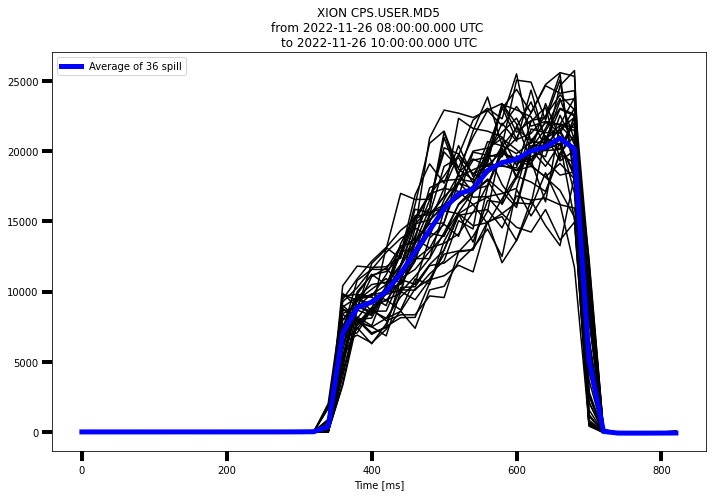

In [111]:
integrationDuration = 840
nbOfSamples = 42
t = np.arange(0, integrationDuration, int(integrationDuration / nbOfSamples))

fig, ax = plt.subplots(tight_layout=True, figsize=(10,7))
for i in range(len(df_xion.semSpillData)):
    if abs(df_xion.semSpillData[i]["elements"]).sum() > 100: # Remove the empty spill
        if (len(df_xion.semSpillData[i]["elements"]) == 42):
            ax.plot(t, -df_xion.semSpillData[i]["elements"], c="k")

mean_spill = np.zeros(42)
no_spill = 0
for i in range(len(df_xion.semSpillData)):
    if (len(df_xion.semSpillData[i]["elements"]) == 42) and (abs(df_xion.semSpillData[i]["elements"]).sum() > 100):
        spill = df_xion.semSpillData[i]["elements"]
        mean_spill += spill
        no_spill += 1
ax.plot(t, -mean_spill/no_spill, color="b", lw=5, label=f"Average of {no_spill} spill")
            
ax.set_title(f"XION {user}\nfrom {start} UTC \nto {end} UTC")
ax.set_xlabel("Time [ms]")
ax.legend()

# XSEC070

In [112]:
df_xsec = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XSEC070-I/SpillData").build().toPandas()
df_xsec = df_xsec.where(df_xsec.selector==user).dropna()
df_xsec.reset_index(drop=True, inplace = True)

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


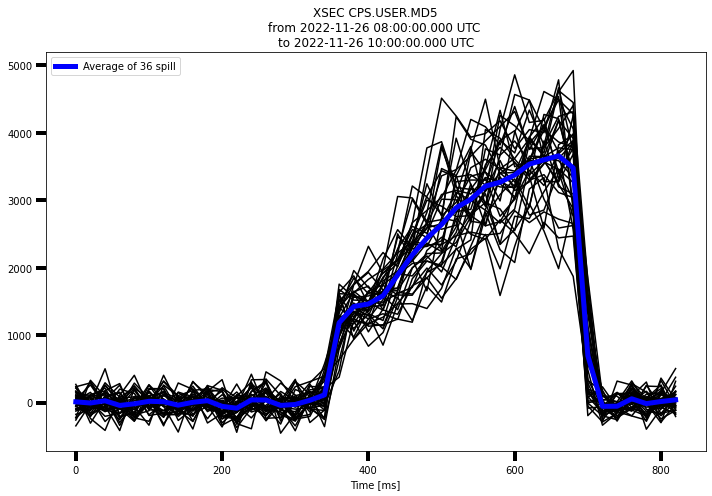

In [113]:
integrationDuration = 840
nbOfSamples = 42
t = np.arange(0, integrationDuration, int(integrationDuration / nbOfSamples))

fig, ax = plt.subplots(tight_layout=True, figsize=(10,7))
for i in range(len(df_xsec.semSpillData)):
    if abs(df_xsec.semSpillData[i]["elements"]).sum() > 10000: # Remove the empty spill
        if (len(df_xsec.semSpillData[i]["elements"]) == 42):
            ax.plot(t, -df_xsec.semSpillData[i]["elements"], c="k")

mean_spill = np.zeros(42)
no_spill = 0
for i in range(len(df_xsec.semSpillData)):
    if (len(df_xsec.semSpillData[i]["elements"]) == 42) and (abs(df_xsec.semSpillData[i]["elements"]).sum() > 10000):
        spill = df_xsec.semSpillData[i]["elements"]
        mean_spill += spill
        no_spill += 1
ax.plot(t, -mean_spill/no_spill, color="b", lw=5, label=f"Average of {no_spill} spill")
            
ax.set_title(f"XSEC {user}\nfrom {start} UTC \nto {end} UTC")
ax.set_xlabel("Time [ms]")
ax.legend()

# All gains

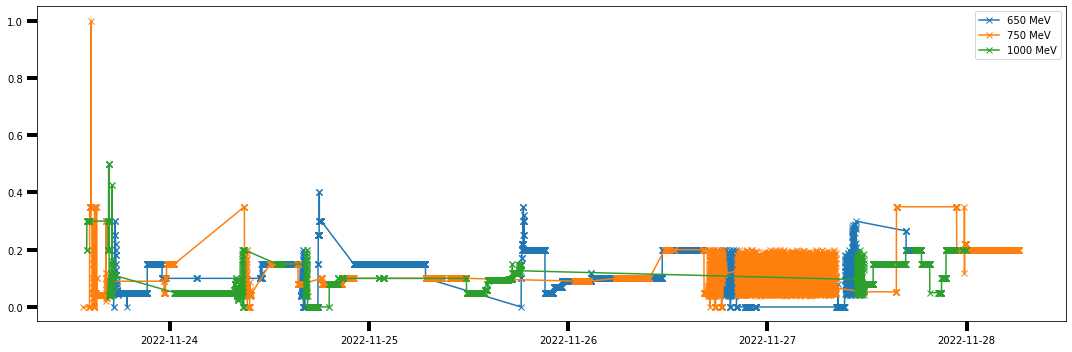

In [114]:
fig, ax = plt.subplots(tight_layout=True, figsize=(15, 5))
ax.plot(df_gain_650.timestamp, df_gain_650.gain, marker="x", label="650 MeV")
ax.plot(df_gain_750.timestamp, df_gain_750.gain, marker="x", label="750 MeV")
ax.plot(df_gain_1000.timestamp, df_gain_1000.gain, marker="x", label="1000 MeV")
ax.legend()

Text(0.5, 1.0, 'User mapped in the supercycle')

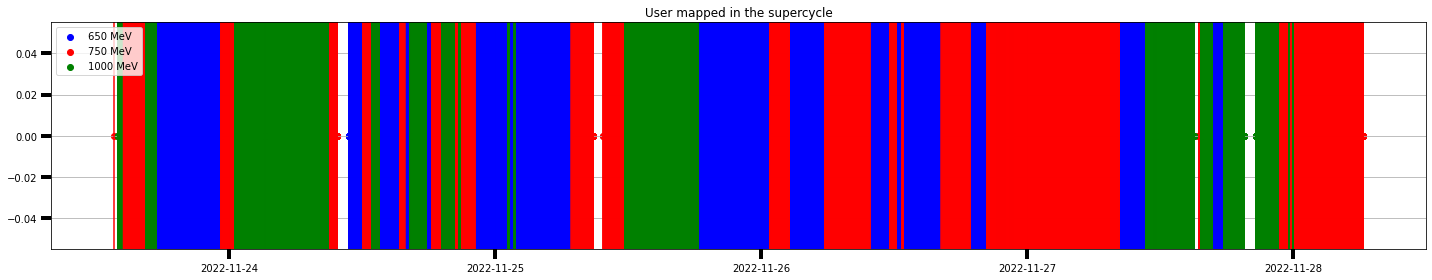

In [115]:
fig, ax = plt.subplots(tight_layout=True, figsize=(20, 4))
ax.scatter(df_gain_650.timestamp, np.zeros(len(df_gain_650)), marker="o", label="650 MeV", color="b")
ax.scatter(df_gain_750.timestamp, np.zeros(len(df_gain_750)), marker="o", label="750 MeV", color="r")
ax.scatter(df_gain_1000.timestamp, np.zeros(len(df_gain_1000)), marker="o", label="1000 MeV", color="g")

for i in range(len(df_gain_650.timestamp)):
    ax.axvline(df_gain_650.timestamp[i], color="b")

for i in range(len(df_gain_750.timestamp)):
    ax.axvline(df_gain_750.timestamp[i], color="r")
    
for i in range(len(df_gain_1000.timestamp)):
    ax.axvline(df_gain_1000.timestamp[i], color="g")

ax.legend(loc="upper left")
ax.grid(zorder=99)
ax.set_title("User mapped in the supercycle")

# Intensity

In [116]:
start = "2022-11-23 12:00:00.000" # UTC
end ="2022-11-25 06:30:00.000" # UTC

df_xion = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XION070-I/SpillData").build().toPandas()
user = "CPS.USER.EAST3"
df_xion = df_xion.where(df_xion.selector==user).dropna()
df_xion.reset_index(drop=True, inplace = True)

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [117]:
df_xion.head(1)

__record_timestamp__  __record_version__      acqStamp   class  \
0          1.669278e+18                 0.0  1.669278e+18  BESTLD   

     cyclestamp         device   property        selector  \
0  1.669278e+18  T08.XION070-I  SpillData  CPS.USER.EAST3   

                                        semSpillData  nxcals_entity_id  
0  {'elements': [0, -1, -1, 0, 0, 0, 0, 0, 0, -1,...        21975127.0

In [118]:
df_xion["intensity"] = df_xion.semSpillData.apply(lambda x: -x["elements"].sum())

In [119]:
fig, ax = plt.subplots(tight_layout=True, figsize=(10,5))

high_intensity_time = df_xion.where(df_xion["intensity"] > 1e2).acqStamp.dropna().apply(lambda x: datetime.fromtimestamp(x/1000000000))
high_intensity_time.reset_index(drop=True, inplace = True)

for i in range(len(high_intensity_time)):
    ax.axvline(high_intensity_time[i], color="b")

ax.scatter(high_intensity_time, np.ones(len(high_intensity_time)))

# Flux

In [120]:
start = str(df_gain_1000.timestamp.min())
end = str(df_gain_1000.timestamp.max())

In [121]:
df_xsec_70_spill = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XSEC070-I/SpillData").build().toPandas()
df_xsec_70_spill = df_xsec_70_spill.dropna()
df_xsec_70_spill.sort_values(by=["acqStamp"])

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


__record_timestamp__  __record_version__             acqStamp   class  \
25748   1669212010300000000                   0  1669212012051000000  BESTLD   
25749   1669212013900000000                   0  1669212015651000000  BESTLD   
24725   1669212017500000000                   0  1669212019341000000  BESTLD   
24726   1669212024700000000                   0  1669212026541000000  BESTLD   
26105   1669212029500000000                   0  1669212031341000000  BESTLD   
...                     ...                 ...                  ...     ...   
4918    1669593486700000000                   0  1669593488541000000  BESTLD   
3995    1669593498700000000                   0  1669593500541000000  BESTLD   
3996    1669593501100000000                   0  1669593502851000000  BESTLD   
1770    1669593527500000000                   0  1669593529341000000  BESTLD   
3997    1669593529900000000                   0  1669593531651000000  BESTLD   

                cyclestamp         device   property        selector  \
25748  1669212010300000000  T08.XSEC070-I  SpillData  CPS.USER.EAST3   
25749  1669212013900000000  T08.XSEC070-I  SpillData    CPS.USER.MD4   
24725  1669212017500000000  T08.XSEC070-I  SpillData    CPS.USER.MD2   
24726  1669212024700000000  T08.XSEC070-I  SpillData  CPS.USER.EAST2   
26105  1669212029500000000  T08.XSEC070-I  SpillData  CPS.USER.EAST2   
...                    ...            ...        ...             ...   
4918   1669593486700000000  T08.XSEC070-I  SpillData  CPS.USER.EAST2   
3995   1669593498700000000  T08.XSEC070-I  SpillData  CPS.USER.EAST2   
3996   1669593501100000000  T08.XSEC070-I  SpillData  CPS.USER.EAST3   
1770   1669593527500000000  T08.XSEC070-I  SpillData  CPS.USER.EAST1   
3997   1669593529900000000  T08.XSEC070-I  SpillData  CPS.USER.EAST3   

                                            semSpillData  nxcals_entity_id  
25748  {'elements': [-220, 149, 36, -27, -43, -147, 3...          22057411  
25749  {'elements': [-175, -105, 277, -159, 87, 48, -...          22057411  
24725  {'elements': [-159, 59, 4, 12, -171, 111, -115...          22057411  
24726  {'elements': [-78, 347, -319, -283, 109, 183, ...          22057411  
26105  {'elements': [71, -146, -196, 137, 196, -95, -...          22057411  
...                                                  ...               ...  
4918   {'elements': [29, 273, -250, -358, 227, 259, -...          22057411  
3995   {'elements': [-52, 56, 76, 175, -60, -215, 211...          22057411  
3996   {'elements': [32, -205, 264, -64, -111, 227, 1...          22057411  
1770   {'elements': [160, 49, -227, 11, 10, -159, 7, ...          22057411  
3997   {'elements': [-8, 51, -58, 180, 29, -26, 116, ...          22057411  

[48273 rows x 10 columns]

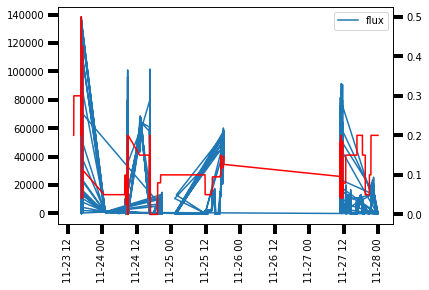

In [122]:
flux = df_xsec_70_spill.where(df_xsec_70_spill.selector=="CPS.USER.EAST4").dropna().semSpillData.apply(lambda x: -x["elements"].sum()*125/400)
spill = df_xsec_70_spill.where(df_xsec_70_spill.selector=="CPS.USER.EAST4").dropna().semSpillData.apply(lambda x: -x["elements"])
acqStamp = df_xsec_70_spill.where(df_xsec_70_spill.selector=="CPS.USER.EAST4").dropna().acqStamp.apply(lambda x: datetime.fromtimestamp(x/1000000000))

d = {'timestamp': acqStamp, 'flux': flux, "spill": spill}
df_flux_1000 = pd.DataFrame(data=d)

fig, ax = plt.subplots()
ax.plot(acqStamp, flux, label="flux")
ax.tick_params(axis='x', rotation=90)

ax2 = ax.twinx()
ax2.plot(df_gain_1000.timestamp, df_gain_1000.gain, color="r", label="gain")
ax.legend()

df_gain_1000.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
df_flux_1000.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
merge_flux_1000 = pd.merge_asof(df_gain_1000, df_flux_1000, on="timestamp", direction="nearest")

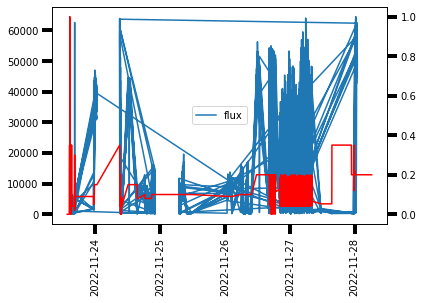

In [143]:
flux = df_xsec_70_spill.where(df_xsec_70_spill.selector=="CPS.USER.EAST3").dropna().semSpillData.apply(lambda x: -x["elements"].sum()*78.5/400+398.6)
spill = df_xsec_70_spill.where(df_xsec_70_spill.selector=="CPS.USER.EAST3").dropna().semSpillData.apply(lambda x: -x["elements"])
acqStamp = df_xsec_70_spill.where(df_xsec_70_spill.selector=="CPS.USER.EAST3").dropna().acqStamp.apply(lambda x: datetime.fromtimestamp(x/1000000000))

d = {'timestamp': acqStamp, 'flux': flux, "spill": spill}
df_flux_750 = pd.DataFrame(data=d)

fig, ax = plt.subplots()
ax.plot(acqStamp, flux, label="flux")
ax.tick_params(axis='x', rotation=90)

ax2 = ax.twinx()
ax2.plot(df_gain_750.timestamp, df_gain_750.gain, color="r", label="gain")
ax.legend()

df_gain_750.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
df_flux_750.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
merge_flux_750 = pd.merge_asof(df_gain_750, df_flux_750, on="timestamp", direction="nearest")

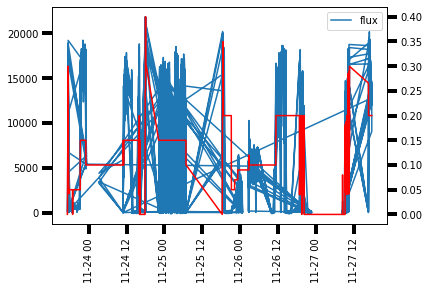

In [144]:
flux = df_xsec_70_spill.where(df_xsec_70_spill.selector=="CPS.USER.MD5").dropna().semSpillData.apply(lambda x: -x["elements"].sum()*34.4/400+58.4)
spill = df_xsec_70_spill.where(df_xsec_70_spill.selector=="CPS.USER.MD5").dropna().semSpillData.apply(lambda x: -x["elements"])
acqStamp = df_xsec_70_spill.where(df_xsec_70_spill.selector=="CPS.USER.MD5").dropna().acqStamp.apply(lambda x: datetime.fromtimestamp(x/1000000000))

d = {'timestamp': acqStamp, 'flux': flux, "spill": spill}
df_flux_650 = pd.DataFrame(data=d)

fig, ax = plt.subplots()
ax.plot(acqStamp, flux, label="flux")
ax.tick_params(axis='x', rotation=90)

ax2 = ax.twinx()
ax2.plot(df_gain_650.timestamp, df_gain_650.gain, color="r", label="gain")
ax.legend()

df_gain_650.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
df_flux_650.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
merge_flux_650 = pd.merge_asof(df_gain_650, df_flux_650, on="timestamp", direction="nearest")

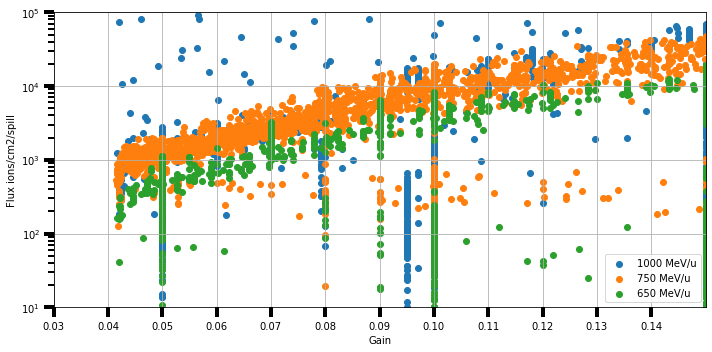

In [145]:
fig, ax = plt.subplots(tight_layout = True, figsize=(10, 5))
ax.scatter(merge_flux_1000.where(merge_flux_1000.gain > 0.0415).gain, merge_flux_1000.where(merge_flux_1000.gain > 0.0415).flux, label="1000 MeV/u")
ax.scatter(merge_flux_750.where(merge_flux_750.gain > 0.0415).gain, merge_flux_750.where(merge_flux_750.gain > 0.0415).flux, label="750 MeV/u")
ax.scatter(merge_flux_650.where(merge_flux_650.gain > 0.0415).gain, merge_flux_650.where(merge_flux_650.gain > 0.0415).flux, label="650 MeV/u")
ax.set_yscale("log")
ax.set_ylim(1e1,1e5)
ax.set_xlim(0.035, 0.15)
ax.set_ylabel("Flux ions/cm2/spill")
ax.set_xlabel("Gain")
ax.grid()
ax.legend()
ax.set_xticks(np.arange(0.03, 0.15, 0.01));

In [146]:
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 2

mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 6
mpl.rcParams['ytick.minor.width'] = 2

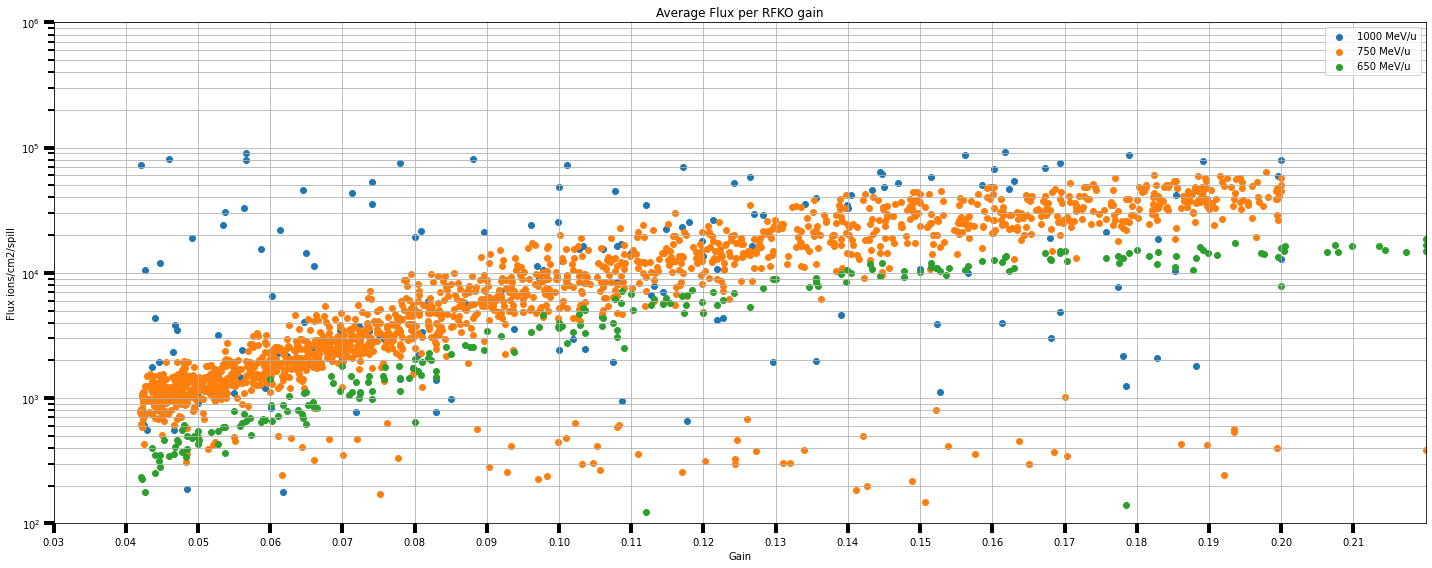

In [147]:
fig, ax = plt.subplots(tight_layout = True, figsize=(20, 8))
threshold_gain = 0.042
intensity_l_1000 = []
for unique_gain in merge_flux_1000.where(merge_flux_1000.gain > threshold_gain).gain.unique():
    intensity_l_1000.append(merge_flux_1000.where(merge_flux_1000.gain > threshold_gain).where(merge_flux_1000.gain == unique_gain).flux.mean())

gain_1000 = merge_flux_1000.where(merge_flux_1000.gain > threshold_gain).gain.unique()
intensity_1000 = np.array(intensity_l_1000)

ax.scatter(gain_1000, intensity_1000, label=f"1000 MeV/u")

intensity_l_750 = []
for unique_gain in merge_flux_750.where(merge_flux_750.gain > threshold_gain).gain.unique():
    intensity_l_750.append(merge_flux_750.where(merge_flux_750.gain > threshold_gain).where(merge_flux_750.gain == unique_gain).flux.mean())


gain_750 = merge_flux_750.where(merge_flux_750.gain > threshold_gain).gain.unique()
intensity_750 = np.array(intensity_l_750)
    
ax.scatter(gain_750, intensity_750, label=f"750 MeV/u")

intensity_l_650 = []
for unique_gain in merge_flux_650.where(merge_flux_650.gain > threshold_gain).gain.unique():
    intensity_l_650.append(merge_flux_650.where(merge_flux_650.gain > threshold_gain).where(merge_flux_650.gain == unique_gain).flux.mean())

gain_650 = merge_flux_650.where(merge_flux_650.gain > threshold_gain).gain.unique()
intensity_650 = np.array(intensity_l_650)

ax.scatter(gain_650, intensity_650, label=f"650 MeV/u")

ax.set_yscale("log")
ax.set_ylim(1e2,1e6)
ax.set_xlim(0.035, 0.22)
ax.set_ylabel("Flux ions/cm2/spill")
ax.set_xlabel("Gain")
ax.legend()
ax.set_title("Average Flux per RFKO gain")
ax.set_xticks(np.arange(0.03, 0.22, 0.01));
ax.grid(True, which="both")

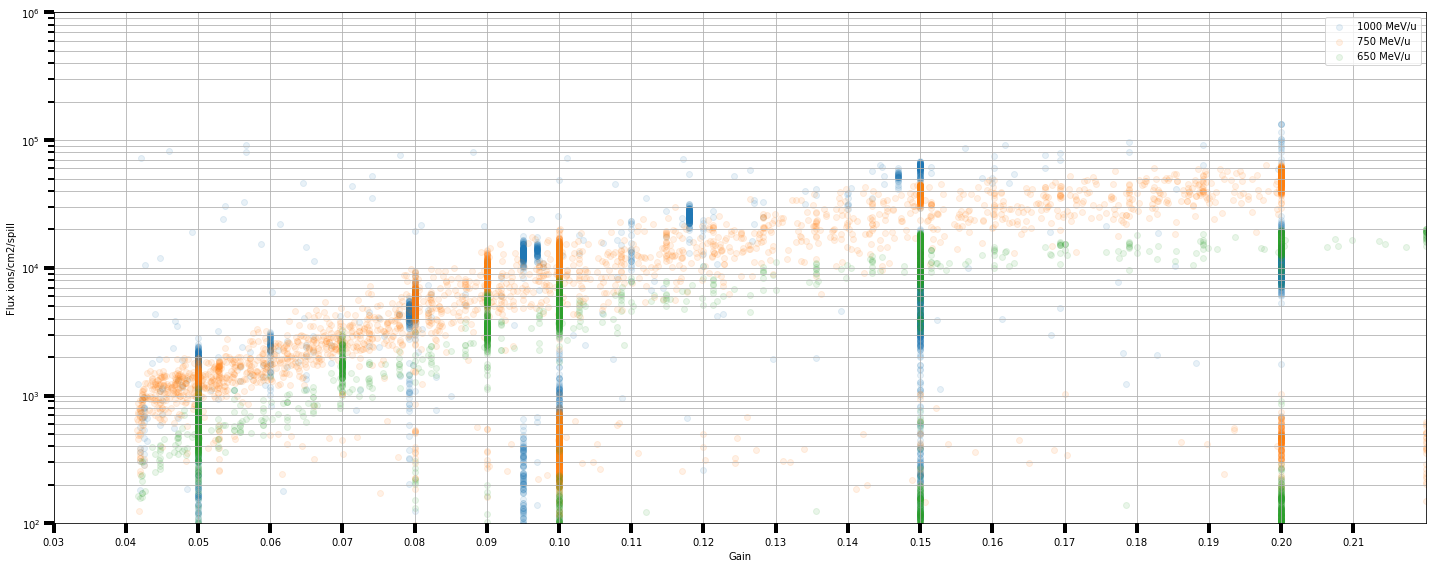

In [148]:
fig, ax = plt.subplots(tight_layout = True, figsize=(20, 8))

ax.scatter(merge_flux_1000.where(merge_flux_1000.gain > 0.0415).gain, merge_flux_1000.where(merge_flux_1000.gain > 0.0415).flux, label="1000 MeV/u", alpha=0.1)
ax.scatter(merge_flux_750.where(merge_flux_750.gain > 0.0415).gain, merge_flux_750.where(merge_flux_750.gain > 0.0415).flux, label="750 MeV/u", alpha=0.1)
ax.scatter(merge_flux_650.where(merge_flux_650.gain > 0.0415).gain, merge_flux_650.where(merge_flux_650.gain > 0.0415).flux, label="650 MeV/u", alpha=0.1)

ax.set_yscale("log")
ax.set_ylim(1e2,1e6)
ax.set_xlim(0.035, 0.22)
ax.set_ylabel("Flux ions/cm2/spill")
ax.set_xlabel("Gain")
ax.legend()
ax.set_xticks(np.arange(0.03, 0.22, 0.01));
ax.grid(True, which="both")

In [129]:
d = {'gain': gain_1000, 'intensity': intensity_1000, 'energy': np.ones(len(intensity_1000))*1000}
df_1000 = pd.DataFrame(data=d)
d = {'gain': gain_750, 'intensity': intensity_750, 'energy': np.ones(len(intensity_750))*750}
df_750 = pd.DataFrame(data=d)
d = {'gain': gain_650, 'intensity': intensity_650, 'energy': np.ones(len(intensity_650))*650}
df_650 = pd.DataFrame(data=d)

my_df = pd.concat([df_1000,df_750,df_650])

In [130]:
# d = {'gain': merge_flux_1000.where(merge_flux_1000.gain > 0.0415).gain, 'intensity': merge_flux_1000.where(merge_flux_1000.gain > 0.0415).flux, 'energy': np.ones(len(merge_flux_1000.where(merge_flux_1000.gain > 0.0415).flux))*1000}
# df_1000 = pd.DataFrame(data=d)
# d = {'gain': merge_flux_750.where(merge_flux_750.gain > 0.0415).gain, 'intensity': merge_flux_750.where(merge_flux_750.gain > 0.0415).flux, 'energy': np.ones(len(merge_flux_750.where(merge_flux_750.gain > 0.0415).flux))*750}
# df_750 = pd.DataFrame(data=d)
# d = {'gain': merge_flux_650.where(merge_flux_650.gain > 0.0415).gain, 'intensity': merge_flux_650.where(merge_flux_650.gain > 0.0415).flux, 'energy': np.ones(len(merge_flux_650.where(merge_flux_650.gain > 0.0415).flux))*650}
# df_650 = pd.DataFrame(data=d)

# my_df = pd.concat([df_1000,df_750,df_650])

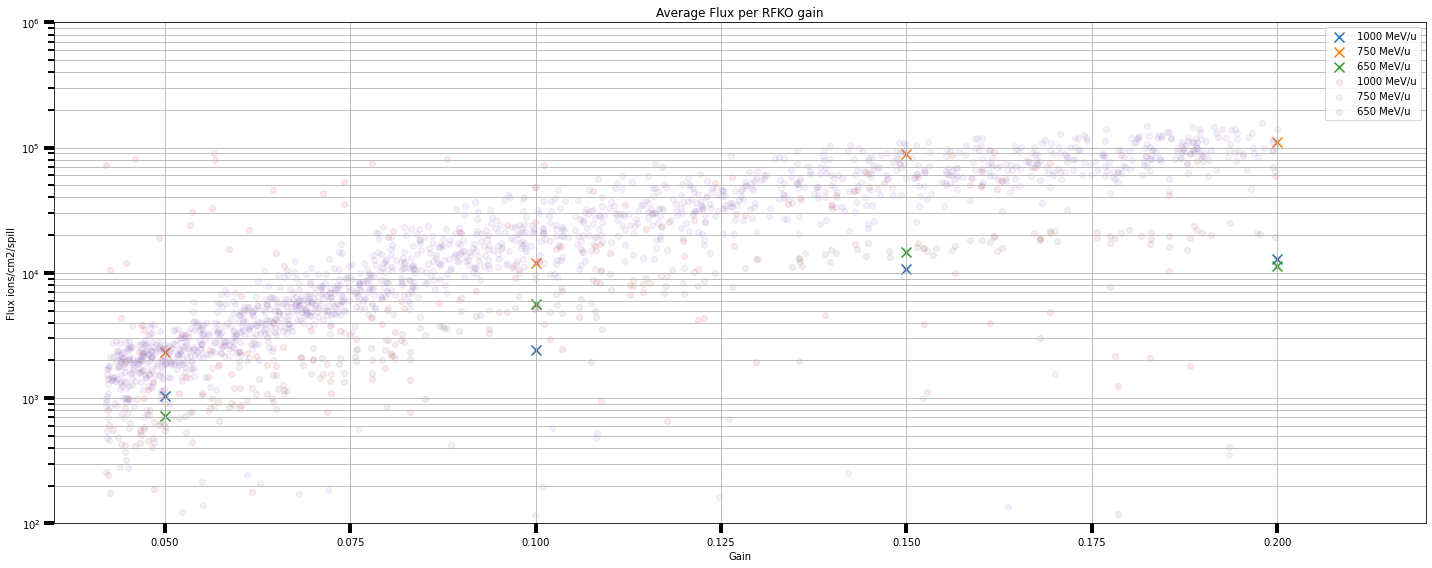

In [131]:
from scipy.optimize import curve_fit


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

fig, ax = plt.subplots(tight_layout = True, figsize=(20, 8))

#####
def piecewise_func(x, a, b, c, d, e):
    x0 = 0.1
    return np.piecewise(x, [x < x0], [lambda x:a*np.exp(b*x) + c, lambda x: d*x**2 + e])

for energy in [1000, 750, 650]:


    df = my_df.where( (my_df.energy == energy) & ( (my_df.gain == 0.05) | (my_df.gain == 0.1) | (my_df.gain == 0.15) | (my_df.gain == 0.2)))
    df = df.where(df.gain<=0.2)
    pd.set_option('mode.use_inf_as_na', True)
    df.dropna(inplace=True)
    df = df.sort_values(by=["gain"])
    df.reset_index(inplace=True, drop=True)

    ax.scatter(df.gain, df.intensity, marker = "x", s=100, label=f"{energy} MeV/u")
    
for energy in [1000, 750, 650]:

    df = my_df.where( (my_df.energy == energy))
    df = df.where(df.gain<=0.2)
    pd.set_option('mode.use_inf_as_na', True)
    df.dropna(inplace=True)
    df = df.sort_values(by=["gain"])
    df.reset_index(inplace=True, drop=True)

    ax.scatter(df.gain, df.intensity, label=f"{energy} MeV/u", alpha=0.1)

# window = 50
# signal_mov_avg = moving_average(df.intensity, window)
# ax.plot(df.gain[window-1:], signal_mov_avg, c="r", label="moving avg", zorder=11)

# x_2_fit = list(df.gain[window-1:])
# y_2_fit = list(signal_mov_avg)

# popt, pcov = curve_fit(piecewise_func, x_2_fit, y_2_fit, maxfev=2000)

# x_fit = np.linspace(min(x_2_fit), 0.2, 100)
# y_fit = piecewise_func(x_fit, *popt)
# ax.plot(x_fit, y_fit)

#####
# def piecewise_func(x, a, b, c, d, e):
#     x0 = 0.075
#     return np.piecewise(x, [x < x0], [lambda x:a*np.exp(b*x) + c, lambda x: d*x**2 + e])

# energy = 1000

# df = my_df.where(my_df.energy == energy)
# df = df.where(df.gain<=0.2)
# pd.set_option('mode.use_inf_as_na', True)
# df.dropna(inplace=True)
# df = df.sort_values(by=["gain"])
# df.reset_index(inplace=True, drop=True)

# ax.scatter(df.gain, df.intensity, label=f"750 MeV/u", alpha=0.1)

# window = 10
# signal_mov_avg = moving_average(df.intensity, window)
# ax.plot(df.gain[window-1:], signal_mov_avg, c="r", label="moving avg", zorder=11)

# x_2_fit = list(df.gain)
# y_2_fit = list(df.intensity)

# popt, pcov = curve_fit(piecewise_func, x_2_fit, y_2_fit, maxfev=50000)

# x_fit = np.linspace(min(x_2_fit), 0.2, 100)
# y_fit = piecewise_func(x_fit, *popt)
# ax.plot(x_fit, y_fit)

#####

ax.set_yscale("log")
ax.set_ylim(1e2,1e6)
ax.set_xlim(0.035, 0.22)
ax.set_ylabel("Flux ions/cm2/spill")
ax.set_xlabel("Gain")
ax.legend()
ax.set_title("Average Flux per RFKO gain")
# ax.set_xticks(np.arange(0.03, 0.22, 0.01));
ax.grid(True, which="both")

In [132]:
d = {'gain': merge_flux_1000.where(merge_flux_1000.gain > threshold_gain).gain.unique(), 'flux': np.array(intensity_l_1000)}
df_flux_1000_inter = pd.DataFrame(data=d)
df_flux_1000_inter.sort_values(by=["gain"], inplace =True)

d = {'gain': merge_flux_750.where(merge_flux_750.gain > threshold_gain).gain.unique(), 'flux': np.array(intensity_l_750)}
df_flux_750_inter = pd.DataFrame(data=d)
df_flux_750_inter.sort_values(by=["gain"], inplace =True)

d = {'gain': merge_flux_650.where(merge_flux_650.gain > threshold_gain).gain.unique(), 'flux': np.array(intensity_l_650)}
df_flux_650_inter = pd.DataFrame(data=d)
df_flux_650_inter.sort_values(by=["gain"], inplace =True)

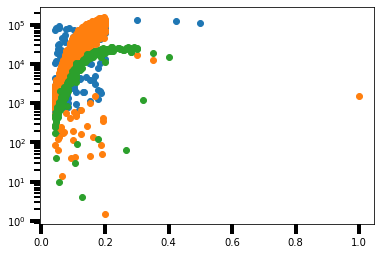

In [133]:
plt.scatter(df_flux_1000_inter.gain, df_flux_1000_inter.flux)
plt.scatter(df_flux_750_inter.gain, df_flux_750_inter.flux)
plt.scatter(df_flux_650_inter.gain, df_flux_650_inter.flux)
plt.yscale("log")

In [134]:
with open('flux_vs_gain_1000.pickle', 'wb') as handle:
    pickle.dump(df_flux_1000_inter, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('flux_vs_gain_750.pickle', 'wb') as handle:
    pickle.dump(df_flux_750_inter, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('flux_vs_gain_650.pickle', 'wb') as handle:
    pickle.dump(df_flux_650_inter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [135]:
df_xion_70_spill = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XION070-I/SpillData").build().toPandas()
df_xion_70_spill = df_xion_70_spill.dropna()
# df_xsec_70_spill.sort_values(by=["acqStamp"])

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [136]:
flux = df_xion_70_spill.where(df_xion_70_spill.selector=="CPS.USER.EAST4").dropna().semSpillData.apply(lambda x: -x["elements"].sum()*125/2000)
spill = df_xion_70_spill.where(df_xion_70_spill.selector=="CPS.USER.EAST4").dropna().semSpillData.apply(lambda x: -x["elements"])
acqStamp = df_xion_70_spill.where(df_xion_70_spill.selector=="CPS.USER.EAST4").dropna().acqStamp.apply(lambda x: datetime.fromtimestamp(x/1000000000))

d = {'timestamp': acqStamp, 'flux': flux, "spill": spill}
df_xion_flux_1000 = pd.DataFrame(data=d)

In [137]:
df_gain_1000.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
df_xion_flux_1000.sort_values(by=['timestamp'], inplace=True, ignore_index=True)
merge_xion_flux_1000 = pd.merge_asof(df_gain_1000, df_xion_flux_1000, on="timestamp", direction="nearest")

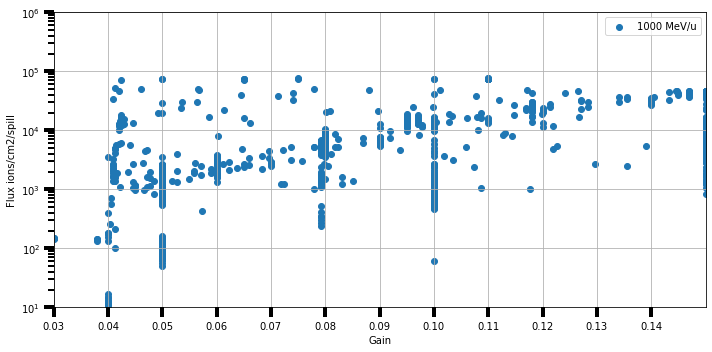

In [138]:
fig, ax = plt.subplots(tight_layout = True, figsize=(10, 5))
ax.scatter(merge_xion_flux_1000.gain, merge_xion_flux_1000.flux, label="1000 MeV/u")
ax.set_yscale("log")
ax.set_ylim(1e1,1e6)
ax.set_xlim(0.035, 0.15)
ax.set_ylabel("Flux ions/cm2/spill")
ax.set_xlabel("Gain")
ax.grid()
ax.legend()
ax.set_xticks(np.arange(0.03, 0.15, 0.01));

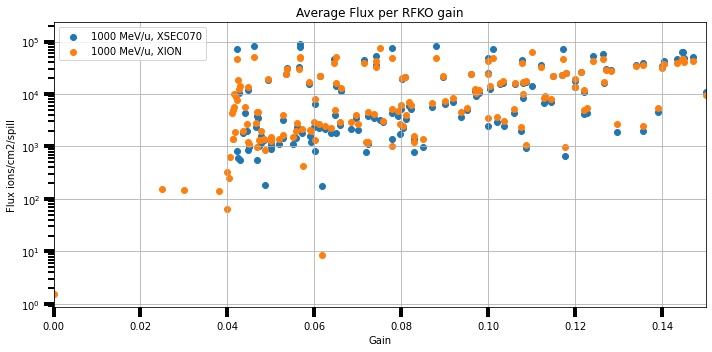

In [139]:
fig, ax = plt.subplots(tight_layout = True, figsize=(10, 5))

intensity_l_xion = []
for unique_gain in merge_xion_flux_1000.gain.unique():
    intensity_l_xion.append(merge_xion_flux_1000.where(merge_xion_flux_1000.gain == unique_gain).flux.mean())

ax.scatter(merge_flux_1000.where(merge_flux_1000.gain > threshold_gain).gain.unique(), np.array(intensity_l_1000), label=f"1000 MeV/u, XSEC070")
ax.scatter(merge_xion_flux_1000.gain.unique(), np.array(intensity_l_xion), label=f"1000 MeV/u, XION")

ax.set_yscale("log")
# ax.set_ylim(1e2,1e5)
ax.set_xlim(0.0, 0.15)
ax.set_ylabel("Flux ions/cm2/spill")
ax.set_xlabel("Gain")
ax.legend()
ax.set_title("Average Flux per RFKO gain")
ax.grid()

In [140]:
merge_xion_flux_1000.where(merge_xion_flux_1000.gain < 0.04).timestamp.dropna().reset_index(drop=True)

0     2022-11-24 08:15:04.871849
1     2022-11-24 08:15:33.671575
2     2022-11-24 08:16:02.471553
3     2022-11-24 08:16:31.271566
4     2022-11-24 08:17:00.071619
                 ...            
218   2022-11-24 17:47:44.471403
219   2022-11-24 17:48:07.271417
220   2022-11-24 17:48:26.472001
221   2022-11-24 19:12:49.273860
222   2022-11-24 19:13:08.472369
Name: timestamp, Length: 223, dtype: datetime64[ns]

In [141]:
df_xion_70_spill

__record_timestamp__  __record_version__             acqStamp   class  \
0       1669507271500000000                   0  1669507273341000000  BESTLD   
1       1669507487500000000                   0  1669507489251000000  BESTLD   
2       1669507522300000000                   0  1669507523971000000  BESTLD   
3       1669507608700000000                   0  1669507610371000000  BESTLD   
4       1669507715500000000                   0  1669507717341000000  BESTLD   
...                     ...                 ...                  ...     ...   
48268   1669420062700000000                   0  1669420064371000000  BESTLD   
48269   1669420267900000000                   0  1669420269741000000  BESTLD   
48270   1669420321900000000                   0  1669420323651000000  BESTLD   
48271   1669420462300000000                   0  1669420464051000000  BESTLD   
48272   1669420743100000000                   0  1669420744771000000  BESTLD   

                cyclestamp         device   property        selector  \
0      1669507271500000000  T08.XION070-I  SpillData  CPS.USER.EAST2   
1      1669507487500000000  T08.XION070-I  SpillData  CPS.USER.EAST3   
2      1669507522300000000  T08.XION070-I  SpillData   CPS.USER.LHC4   
3      1669507608700000000  T08.XION070-I  SpillData   CPS.USER.LHC4   
4      1669507715500000000  T08.XION070-I  SpillData  CPS.USER.EAST2   
...                    ...            ...        ...             ...   
48268  1669420062700000000  T08.XION070-I  SpillData   CPS.USER.LHC4   
48269  1669420267900000000  T08.XION070-I  SpillData  CPS.USER.EAST2   
48270  1669420321900000000  T08.XION070-I  SpillData  CPS.USER.EAST3   
48271  1669420462300000000  T08.XION070-I  SpillData  CPS.USER.EAST3   
48272  1669420743100000000  T08.XION070-I  SpillData   CPS.USER.LHC4   

                                            semSpillData  nxcals_entity_id  
0      {'elements': [0, 0, 0, -1, -1, -1, 0, 0, 0, 0,...          21975127  
1      {'elements': [-1, -1, -1, 0, 1, 0, 0, -1, -1, ...          21975127  
2      {'elements': [-1, -1, 0, 0, 0, -1, -1, -1, -1,...          21975127  
3      {'elements': [0, 0, 0, 0, 0, -1, -1, -1, 0, 0,...          21975127  
4      {'elements': [1, -1, -1, -1, -1, 0, 0, 0, 0, -...          21975127  
...                                                  ...               ...  
48268  {'elements': [0, -1, 0, -1, 0, 0, 0, 0, -1, -1...          21975127  
48269  {'elements': [0, 9, 10, 2, -9, -15, -11, -1, 7...          21975127  
48270  {'elements': [0, 0, 0, 0, -1, -1, -1, 0, 0, 0,...          21975127  
48271  {'elements': [0, 0, 0, 0, 0, -1, -1, 0, 0, 0, ...          21975127  
48272  {'elements': [-4, -1, 2, 3, 2, -1, -4, -4, -1,...          21975127  

[48273 rows x 10 columns]